In [25]:
#Import Bibliotecas
import pypsa
import pandas as pd
import numpy as np


In [27]:

# ===========
# Zeitprofile
# ===========

# Lade das ninja_pv Solar-Profil für Deutschland (51.16°N, 13°E)
renewable_profile_solar = (pd.read_csv("pv_profile.csv", usecols=["electricity"]) ["electricity"].astype(float))  # Stündliches, normiertes PV-Erzeugungsprofil

#building load als csv datei einlesen 
electric_load_profile = pd.read_csv("building_electric_load.csv", usecols=["Gebaeude_Strom_Gesamt_kW"])["Gebaeude_Strom_Gesamt_kW"].astype(float)  # Stündliches, normiertes Lastprofil für das Gebäude

#building thermal load als csv datei einlesen 
thermal_load_bww = pd.read_csv("bww_load.csv", header=None)[1].astype(float)
thermal_load_heating = pd.read_csv("building_heat_load.csv", header=None)[1].astype(float)

#temprature profile
temperature_profile = pd.read_csv("temprature_profile.csv", header=None)[2].astype(float)

#zeitprofile fleet_loead_hourly
fleet_load_profile = pd.read_csv("fleet_load.csv", header=None)[1].astype(float)

In [28]:
# ===============================
#netzwerk erstellen with_batterie
# ===============================

with_battery = pypsa.Network()
with_battery.set_snapshots(range(8760))



In [29]:
#hinzufügen bus
with_battery.add("Bus", name="electricity bus", carrier="electricity")
with_battery.add("Bus", name= "h_bus", carrier="heat")
with_battery.add("Bus", name= "h_bus2", carrier="heat")


In [ ]:
#hinzufügen generatoren
inhouse_pv = 0.35 #leistung der PV Anlage in MW
with_battery.add("Generator", name="PV", bus="electricity bus", p_nom=inhouse_pv, p_max_pu=renewable_profile_solar, marginal_cost=1)  # PV Betriebskosten: 1 €/MWh
with_battery.add("Generator", name="Grid", bus="electricity bus", p_nom_extendable=True, marginal_cost=150)  # Netzbezug: 150 €/MWh (15 Cent/kWh), fixe Leistung 10 MW


In [31]:
#hinzufügen last
with_battery.add("Load", name="building_load", bus="electricity bus", p_set=electric_load_profile)
with_battery.add("Load", name="fleet_load", bus="electricity bus", p_set=fleet_load_profile)
with_battery.add("Load", "DHW_Load",bus="h_bus", p_set=thermal_load_bww)
with_battery.add("Load", "Heating_Load",bus="h_bus2", p_set=thermal_load_heating)


In [32]:
#wärmepumpen

# Umgebungstemperatur in °C
temp        = [-20, -15, -10,  -7,   2,   7,  10,  20,  30,  35] 
# Elektrische Leistungsaufnahme in kW 
el_power    = [10.2, 10.4, 10.6, 10.8, 11.2, 11.5, 11.7, 12.0, 12.2, 12.5] 
# Leistungszahl (COP) der Wärmepumpe bei 35°C Vorlauftemperatur
cop         = [1.65, 1.90, 2.20, 2.50, 3.40, 4.60, 5.10, 6.20, 7.10, 7.50]
# Nominale thermische Leistung (P_th) bei A7/W35 (Referenzpunkt)
hp_p_nom    = 39.5 # kW (thermisch)

# Interpolation für jede Stunde des Jahres
cop_profile = np.interp(temperature_profile, temp, cop)
el_p_pu_profile = np.interp(temperature_profile, temp, el_power) / hp_p_nom

# Wärmepumpe 1: Raumheizung (h_bus2)
with_battery.add("Link", name="h_pump", 
                 bus0="electricity bus", 
                 bus1="h_bus2", 
                 efficiency=cop_profile,  # Temperaturabhängig!
                 p_max_pu=el_p_pu_profile,  # Leistungsbegrenzung
                 p_nom_extendable=True)

# Wärmepumpe 2: Warmwasser (h_bus)
with_battery.add("Link", name="h_pump2", 
                 bus0="electricity bus", 
                 bus1="h_bus", 
                 efficiency=cop_profile,  # Temperaturabhängig!
                 p_max_pu=el_p_pu_profile,  # Leistungsbegrenzung
                 p_nom_extendable=True)



In [33]:
#hinzufügen Wärmespeicher
with_battery.add("Store", name="DHW_Storage", bus="h_bus", carrier="heat", e_nom_extendable=True, e_cyclic=True, capital_cost=1)  # 5 MWh Speicher, 0.5% Verlust/h
with_battery.add("Store", name="Thermal_Storage", bus="h_bus2", carrier="heat", e_nom_extendable=True, e_cyclic=True, capital_cost=1)


In [34]:
#hinzufügen Batteriespeicher
with_battery.add("Store", name="Battery", bus="electricity bus", carrier="electricity", e_nom_extendable=True, e_cyclic=True, capital_cost=1)

In [35]:
with_battery.optimize(solver_name='highs')

Index(['electricity bus', 'h_bus', 'h_bus2'], dtype='object', name='name')
Index(['h_pump', 'h_pump2'], dtype='object', name='name')
Index(['DHW_Storage', 'Thermal_Storage', 'Battery'], dtype='object', name='name')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 356.59it/s]
INFO:linopy.io: Writing time: 0.27s


Running HiGHS 1.12.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
LP linopy-problem-t6zz1aj9 has 175206 rows; 87606 cols; 332886 nonzeros
Coefficient ranges:
  Matrix  [3e-01, 8e+00]
  Cost    [1e+00, 2e+02]
  Bound   [0e+00, 0e+00]
  RHS     [3e-09, 7e+02]
Presolving model
61320 rows, 65433 cols, 170550 nonzeros  0s
50275 rows, 54388 cols, 151881 nonzeros  0s
Dependent equations search running on 23419 equations with time limit of 1000.00s
Dependent equations search removed 0 rows and 0 nonzeros in 0.00s (limit = 1000.00s)
49699 rows, 53812 cols, 154394 nonzeros  0s
Presolve reductions: rows 49699(-125507); columns 53812(-33794); nonzeros 154394(-178492) 
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -1.5309924055e+01 Pr: 22849(6.77515e+06) 0s
      21813     4.9821890981e+08 Pr: 8758(1.74017e+07); Du: 0(4.87254e-16) 5s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87606 primals, 175206 duals
Objective: 4.99e+08
Solver model: available
Solver message: Optimal



      32558     4.9911961898e+08 Pr: 0(0); Du: 1(0.5) 10s
      32662     4.9911960182e+08 Pr: 0(0) 10s
      32662     4.9911960182e+08 Pr: 0(0) 10s

Performed postsolve
Solving the original LP from the solution after postsolve

Model name          : linopy-problem-t6zz1aj9
Model status        : Optimal
Simplex   iterations: 32662
Objective value     :  4.9911960182e+08
P-D objective error :  1.2061375859e-14
HiGHS run time      :         10.36


INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.


('ok', 'optimal')

In [ ]:
print

sf

=== Optimale Kapazitäten ===
Grid Leistung: 71150.49 MW
PV Leistung: 0.35 MW
Wärmepumpe 1: 208787.05 MW
Wärmepumpe 2: 15881.95 MW
DHW Speicher: 37693.00 MWh
Thermal Speicher: 495538.89 MWh

=== Energiemengen (MWh/Jahr) ===
PV Erzeugung: 458.1 MWh
Netzbezug: 3323906.1 MWh

=== Kosten-Aufschlüsselung (€/Jahr) ===
PV Kosten: 458 €
Grid Kosten: 498585912 €
Wärmepumpen Betrieb: 144527 €
Gesamtkosten (Betrieb): 498730897 €

=== Gesamtoptimierungskosten: 499119602 € ===


<Axes: xlabel='snapshot'>

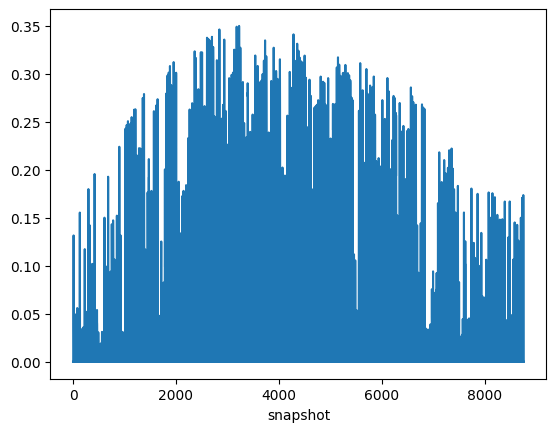

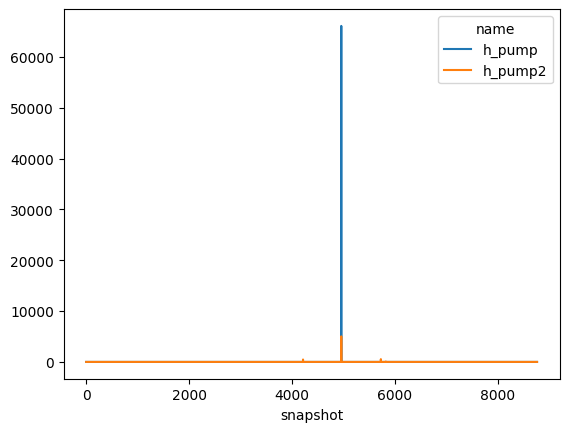

In [ ]:
# ============================
# Ergebnisse abrufen & Analyse
# ============================

# 1. Optimale Kapazitäten (extendable components)
print("=== Optimale Kapazitäten ===")
print(f"Grid Leistung: {with_battery.generators.loc['Grid', 'p_nom_opt']:.2f} MW")
print(f"PV Leistung: {with_battery.generators.loc['PV', 'p_nom_opt']:.2f} MW")
print(f"Wärmepumpe 1: {with_battery.links.loc['h_pump', 'p_nom_opt']:.2f} MW")
print(f"Wärmepumpe 2: {with_battery.links.loc['h_pump2', 'p_nom_opt']:.2f} MW")
print(f"DHW Speicher: {with_battery.stores.loc['DHW_Storage', 'e_nom_opt']:.2f} MWh")
print(f"Thermal Speicher: {with_battery.stores.loc['Thermal_Storage', 'e_nom_opt']:.2f} MWh")
#print(f"Battery: {with_battery.stores.loc['Battery', 'e_nom_opt']:.2f} MWh")

# 2. Energiemengen pro Komponente
print("\n=== Energiemengen (MWh/Jahr) ===")
pv_energy = with_battery.generators_t.p["PV"].sum()
grid_energy = with_battery.generators_t.p["Grid"].sum()
print(f"PV Erzeugung: {pv_energy:.1f} MWh")
print(f"Netzbezug: {grid_energy:.1f} MWh")

# 3. Kosten-Aufschlüsselung
print("\n=== Kosten-Aufschlüsselung (€/Jahr) ===")
pv_cost = pv_energy * 1  # marginal_cost=1
grid_cost = grid_energy * 150  # marginal_cost=150
h_pump_energy = with_battery.links_t.p0["h_pump"].sum() + with_battery.links_t.p0["h_pump2"].sum()
h_pump_cost = h_pump_energy * 2  # marginal_cost=2
print(f"PV Kosten: {pv_cost:.0f} €")
print(f"Grid Kosten: {grid_cost:.0f} €")
print(f"Wärmepumpen Betrieb: {h_pump_cost:.0f} €")
print(f"Gesamtkosten (Betrieb): {pv_cost + grid_cost + h_pump_cost:.0f} €")

# 4. Optimale Zielfunktion
print(f"\n=== Gesamtoptimierungskosten: {with_battery.objective:.0f} € ===")

# 5. Last-Analyse
print("\n=== Lasten (MWh/Jahr) ===")
building_load = with_battery.loads_t.p["building_load"].sum()
fleet_load = with_battery.loads_t.p["fleet_load"].sum()
dhw_load = with_battery.loads_t.p["DHW_Load"].sum()
thermal_load = with_battery.loads_t.p["Thermal_Load"].sum()
print(f"Gebäudelast: {building_load:.1f} MWh")
print(f"Fahrzeuglast: {fleet_load:.1f} MWh")
print(f"DHW-Last: {dhw_load:.1f} MWh")
print(f"Thermische Last: {thermal_load:.1f} MWh")
print(f"Gesamt-Last: {building_load + fleet_load + dhw_load + thermal_load:.1f} MWh")

with_battery.generators.p_nom_opt
 
with_battery.generators_t.p['PV'].plot()
with_battery.links_t.p0.plot()
